In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Слои нейроннов

## Полносвязный слой
Полносвязный слой в Tensorflow называется Dense и живет в tensorflow.keras.layers.

Он имеет следующие параметры (показаны лишь самые основные):

```
Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', ...)
```

* units -- количество нейронов на выходе из слоя
* activation -- функция активации, например "sigmoid", "relu", "softmax". по умолчанию -- слой без активации
* use_bias -- применять ли bias
* kernel_initializer и bias_initializer -- правила инициализации матрицы весов (kernel) и баеса. Это часто используемые значения "по-умолчанию". Скорее всего вам не придется их никогда менять)
* input_shape -- количество нейронов на входном слое. (Указывать только в 1 слое нейронной сети)

In [4]:
x = np.ones((4, 3)) # 4 объекта, 3 признака

dense_layer = Dense(units=2, input_shape=(3,))
output = dense_layer(x)
print(f"Output: {output}")

Output: [[ 0.46779853 -0.6233072 ]
 [ 0.46779853 -0.6233072 ]
 [ 0.46779853 -0.6233072 ]
 [ 0.46779853 -0.6233072 ]]


## Сверточный слой

сверточный слой находится в tf.keras.layers и называется Conv2D

 <img src="https://drive.google.com/uc?export=view&id=1s5twLjOyr46Z1X-TbsodlmtVxBoDtZac" width=600>

Он имеет следующие параметры (показаны лишь самые основные):

```
Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', ...)
```


*   filters -- количество выходных каналов. M -- на иллюстрации выше
*   kernel_size -- размер фильтра (ядра). (k,k) -- на иллюстрации.
*   padding -- значение "valid" по умолчанию, означает, что свертка "откусит" часть входного тензора. Например, при размере фильтра 3 -- размер уменьшится на пиксель с каждой стороны, при фильтре 5 -- на два и т.д. Второе значение -- "same", автоматически подберет паддинг из нулей для того, чтобы размер не изменился
*   activation -- знакомая нам активация (например, "relu"). Применяется сразу после свертки и добавления вектора смещения поэлементно
*   use_bias -- использовать ли смещение после свертки. Добавляет число к каждому из выходных каналов
*   kernel_initializer, bias_initializer -- инициализаторы ядра и смещения, аналогично Dense слою

Обратите внимаение, мы не указали количество входных каналов. Как и в случае полносвязного слоя, Keras вычислит это автоматически.

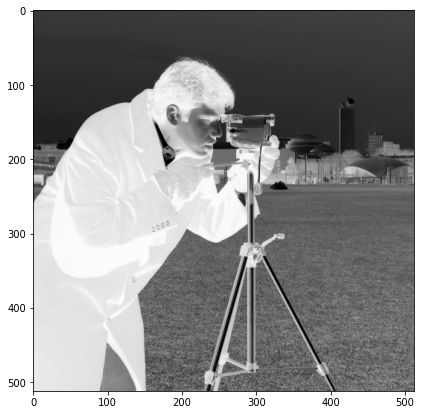

In [47]:
from skimage import data

image = data.camera()
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap="gray_r")

In [48]:
image = image[None, ... , None]  # так тоже можно добавлять дополнительные размерности
image = image.astype(np.float32) / 255. # !!! обязательно приводим к флоату.

conv_layer = Conv2D(kernel_size=(7, 7), filters=1, use_bias=False) # мы используем фильтр размера (7, 7).
# и т.к. мы хотим получить на выходе также одноканальное изображение,
# укажем количество каналов на выходе = 1
_ = conv_layer(image) # чтобы получить доступ к весам слоя нужно один раз им воспользоваться.

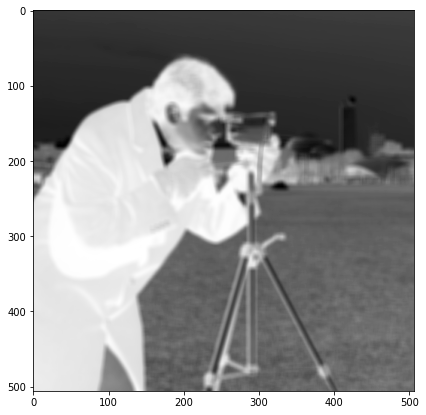

In [49]:
kernel = np.ones((7, 7, 1, 1)) * 1./49 # усредняем значение всех пикселей, которые попали в окошко (7,7)
conv_layer.set_weights([kernel])

blur_image = conv_layer(image).numpy()
plt.figure(figsize=(7, 7))
plt.imshow(blur_image[0, :, :, 0], cmap="gray_r")

## GlobalAveragePooling

Он просто считает среднее по каждому из каналов. И мы получим вектор! (точнее тензор размера 1 x 1 x n_channels).
<img src="https://peltarion.com/static/global_average_pooling_a.png" width="600">

# Типы моделей

## Sequential Model

Sequential создает каркас модели, в который затем последовательно добавляются слой за слоем с помощью метода add.

In [6]:
model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(10,), activation="relu")) # скрытый слой 1
model.add(Dense(20, activation="relu",
                bias_initializer=tf.keras.initializers.Constant(2.0))) # скрытый слой 2, с не дефолтной инициализацией
model.add(Dense(5, activation="softmax")) # выходной слой

sample_input = np.random.rand(2, 10)
output = model(sample_input)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 20)                220       
                                                                 
 dense_6 (Dense)             (None, 5)                 105       
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


## Functional API

Для понимания Functional API нужно начать относится к сети как к графу. В таком случае в роли вершин вступают слои, а ребра связывают выход одного слоя с входом другого.

In [40]:
# cпециальный Инпут слой, показывает keras куда "положить" данные при использовании модели
input_layer = tf.keras.layers.Input(shape=(10, ), name="Input")
l1 = Dense(10, name="Layer1") # определили первый слой
l1_output = l1(input_layer) # соеденили его с инпутом, "нарисовали" самую правую стрелку на картинке выше

l2_output = Dense(10, name="Layer2")(input_layer) # дальше будем определять чуть компактнее
l3_output = Dense(10, name="Layer3")(l2_output)
l4_output = Dense(10, name="Layer4")(l3_output)

l5_output = Dense(10, name="Layer5")(l2_output)

# специальный слой, который сложит выходы всех слоев, которые ему передали
sum_output = tf.keras.layers.Add(name="SumLayer")([l1_output, l4_output, l5_output])

# выходной слой
output = Dense(10, name="Output")(sum_output)

# создаем модель. нужно показать что мы считаем входом в нашу модель, а что выходом.
model = tf.keras.Model(inputs=input_layer, outputs=output)

tf.keras.utils.plot_model(model, show_shapes=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Функции активации

# Функции потерь

## MSE (mean squared error)

In [ ]:
loss = tf.keras.losses.MSE

## BCE (binary cross entropy)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy

## Categorical cross entropy

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy

# Оптимизаторы

## Adam

In [8]:
tf.keras.optimizers.Adam

## SGD

In [ ]:
tf.keras.optimizers.SGD

# Обучение модели

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
X = np.array([[10, 6], [7, 4], [6, 6], [9, 8], [10, 10],
              [10, 4], [4, 4], [4, 6], [8, 9]])
y = np.array([0, 1, 0, 0, 0, 1, 1, 1, 1])


In [13]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1024, input_shape=(2,), activation="sigmoid"))
    model.add(tf.keras.layers.Dense(1)) # мы хотим визуализировать логиты, поэтому без активации

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # лосс -- с логитами

    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) # для дополнительного контроля
    #-- просим сообщать не только лосс, но и точность.
    history = model.fit(X, y, epochs=2000, verbose=2)

Epoch 1/2000
1/1 - 1s - loss: 0.7205 - accuracy: 0.4444 - 549ms/epoch - 549ms/step
Epoch 2/2000
1/1 - 0s - loss: 8.5838 - accuracy: 0.5556 - 5ms/epoch - 5ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.8624 - accuracy: 0.5556 - 6ms/epoch - 6ms/step
Epoch 4/2000
1/1 - 0s - loss: 2.3262 - accuracy: 0.4444 - 5ms/epoch - 5ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.5109 - accuracy: 0.7778 - 6ms/epoch - 6ms/step
Epoch 6/2000
1/1 - 0s - loss: 1.3170 - accuracy: 0.5556 - 6ms/epoch - 6ms/step
Epoch 7/2000
1/1 - 0s - loss: 1.0889 - accuracy: 0.5556 - 5ms/epoch - 5ms/step
Epoch 8/2000
1/1 - 0s - loss: 0.5441 - accuracy: 0.7778 - 4ms/epoch - 4ms/step
Epoch 9/2000
1/1 - 0s - loss: 0.6389 - accuracy: 0.6667 - 7ms/epoch - 7ms/step
Epoch 10/2000
1/1 - 0s - loss: 0.8806 - accuracy: 0.5556 - 8ms/epoch - 8ms/step
Epoch 11/2000
1/1 - 0s - loss: 0.7355 - accuracy: 0.5556 - 7ms/epoch - 7ms/step
Epoch 12/2000
1/1 - 0s - loss: 0.5234 - accuracy: 0.7778 - 5ms/epoch - 5ms/step
Epoch 13/2000
1/1 - 0s - loss: 0.5137 - accur

In [24]:
pd.DataFrame(history.history).head()

,loss,accuracy
0,0.703670,0.444444
1,0.692658,0.444444
2,0.690511,0.444444
3,0.690582,0.444444
4,0.689357,0.444444


# Сохранение модели

In [35]:
dataset = pd.read_csv("data/pima-indians-diabetes.data.csv", header=None)
dataset.columns = ["number_times_pregnant",
                   "plasma_glucose_concent","blood_pressure",
                   "skin_thickness", "insulin", "BMI", "diabetes_pedigree", "age", "has_diabetes"]
dataset.head()

,number_times_pregnant,plasma_glucose_concent,blood_pressure,skin_thickness,insulin,BMI,diabetes_pedigree,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
np.random.seed(10)
X = dataset.drop(['has_diabetes'], axis=1).values
y = dataset['has_diabetes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Labels ratio: {y_train.mean():.2f}")

Train shape: (614, 8), Test shape: (154, 8), Labels ratio: 0.34


In [37]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(24, input_dim=8, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

За запись чекпоинтов в keras отвечает **tf.keras.callbacks.ModelCheckpoint**. Как видно из пути к модулю -- он относится к коллбекам (callbacks). Можно смотреть на них как на функции, которые вызывает метод model.fit внутри себя.

То есть каждый раз, когда отработает одна из эпох цикла, будет запускаться функция, которую мы укажем. Бывают коллбеки, которые вызываются на каждой итерации (например [прогресс бар](https://keras.io/callbacks/#progbarlogger), который мы видим при обучении -- это тоже коллбэк). Чуть ниже мы разберем конкретный пример.

Вернемся к **tf.keras.callbacks.ModelCheckpoint**.

```
tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', ...)
```

Он имеет один обязательный параметр -- имя чекпоинта. Оно может быть отформатировано с использованием служебных переменных (пример ниже). Из необязательных, но полезных параметров:

*   monitor (str): название метрики за которой нужно "следить"
*   verbose -- печатать ли дополнительную информацию
*   save_best_only (bool): сохранять чекпоинт только после улучшения метрики, указанной в monitor
*   save_weights_only (bool): помимо весов модели можно еще сохранять ее архитектуру и состояние оптимизатора. В примерах мы так и будем делать, если не сказано обратное. По умолчанию -- false.
*   mode (str): если метрику нужно максимизировать -- max, иначе -- min.


**Таким образом, если выбрано save_best_only, то чекпоинты будут сохранятся только после тех эпох, когда произошло улучшение метрики, которую мы указали в monitor. Т.к. понятие "лучше" -- разное для разных метрик, необходимо также указать режим -- max/min (больше -- лучше/меньше -- лучше). Пример таких метрик -- лосс (min) и точность (max)**.

In [38]:
path = Path("model_save")
path.mkdir(exist_ok=True) # создаем папку на диске
cpt_filename = "{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [39]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=64, verbose=0,
          callbacks=[checkpoint])


Epoch 1: val_loss improved from inf to 1.93453, saving model to model_save\01_checkpoint_1.93.hdf5

Epoch 2: val_loss improved from 1.93453 to 1.09240, saving model to model_save\02_checkpoint_1.09.hdf5

Epoch 3: val_loss improved from 1.09240 to 0.82671, saving model to model_save\03_checkpoint_0.83.hdf5

Epoch 4: val_loss improved from 0.82671 to 0.64201, saving model to model_save\04_checkpoint_0.64.hdf5

Epoch 5: val_loss did not improve from 0.64201

Epoch 6: val_loss improved from 0.64201 to 0.61946, saving model to model_save\06_checkpoint_0.62.hdf5

Epoch 7: val_loss did not improve from 0.61946

Epoch 8: val_loss did not improve from 0.61946

Epoch 9: val_loss did not improve from 0.61946

Epoch 10: val_loss did not improve from 0.61946

Epoch 11: val_loss did not improve from 0.61946

Epoch 12: val_loss did not improve from 0.61946

Epoch 13: val_loss did not improve from 0.61946

Epoch 14: val_loss did not improve from 0.61946

Epoch 15: val_loss did not improve from 0.6194

In [ ]:
model.load_weights("model_save/105_checkpoint_0.55.hdf5") # загружаем веса.

# т.к. мы сохраняли и веса и модель, то мы можем загрузить модель не определяя ее
model = tf.keras.models.load_model("model_save/105_checkpoint_0.55.hdf5")


# Аугментация

Мы можем немного разнообразить наш датасет с помощью искусственных изменений изображений, которые не меняют его класса. Это называется аугментация.

Аугментация искусственно делает датасет более разнообразным. Это очень эффективный метод борьбы с переобчуением, но у него конечно есть пределы -- все-таки новых данных мы не добавляем.

In [14]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'


In [15]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    names = {0: "Cat", 1: "Dog"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [16]:
# а теперь мы попросим его изменять изображение на лету, добавляя повороты, отражения и тд
image_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # максимальный угол поворота
    width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
    height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
    zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    #cval=0,
)

image_gen_no_aug = ImageDataGenerator(rescale=1./255)

sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary',
                                                     )

sample_aug = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=False,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


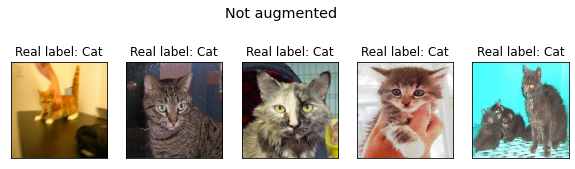

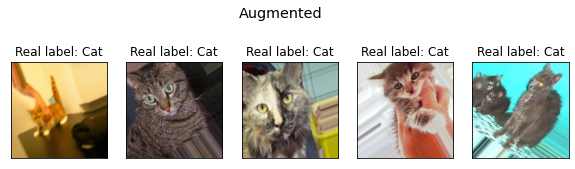

In [17]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(sample_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Augmented")

# Transfer learning

In [4]:
import os
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#tf.enable_eager_execution()

BATCH_SIZE = 100
IMG_SHAPE  = 150

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # указываем preprocessing_function !!!

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [7]:
IMG_SHAPE = (150, 150, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


C:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

Epoch 1/30


In [4]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

NameError: name 'base_model' is not defined

In [ ]:
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = (model.predict(sample_validation_images) > 0.5).astype("int32").flatten()


show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

# Использование готовых моделей

In [35]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet')

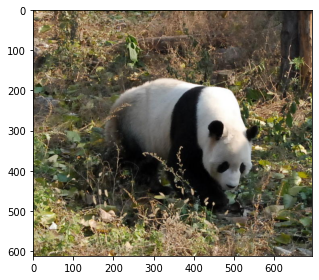

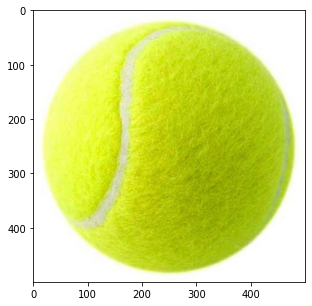

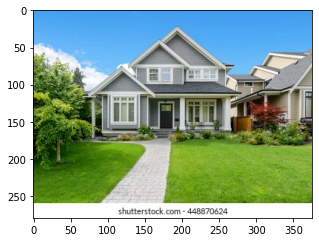

In [36]:
def read_and_show(path):
    image = plt.imread(path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    return image

panda = read_and_show("img/panda.jpg")
ball = read_and_show("img/ball.jpg")
house = read_and_show("img/house.jpg")

In [37]:
# попробуем применить сеть к нашему изображению?
vgg19.predict(panda.astype(np.float32)[None, ...])

ValueError: in user code:

    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vgg19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 613, 696, 3)


In [38]:
# оказывается, модель ожидает определенный размер, учтем это

def prepare_image(image, image_size):
    image = tf.image.resize(image, image_size)
    return image[None, ...]


prepare_image(panda, (224, 224)).numpy().shape

(1, 224, 224, 3)

In [39]:
input_image = prepare_image(panda, (224, 224))
prediction = vgg19.predict(input_image)

prediction.sum(), prediction.shape # предсказали вероятности 1000 классов. а как расшифровать?

1/1 [==============================] - 1s 553ms/step


(0.99999994, (1, 1000))

In [40]:
from tensorflow.keras.applications.vgg19 import decode_predictions

input_image = prepare_image(panda, (224, 224))
prediction = vgg19.predict(input_image)
decode_predictions(prediction)

1/1 [==============================] - 0s 332ms/step


[[('n02510455', 'giant_panda', 0.9649041),
  ('n02395406', 'hog', 0.013631305),
  ('n02134084', 'ice_bear', 0.007675218),
  ('n02120079', 'Arctic_fox', 0.007050972),
  ('n02108915', 'French_bulldog', 0.0020282778)]]

На самом деле в примере выше нам повезло. Мы забыли очень важную часть -- препроцессинг картинки. Для каждой сети он свой и находитя рядом с ней:

In [41]:
from tensorflow.keras.applications.vgg19 import preprocess_input
# добавим этап препроцессинга и получим еще более правильный ответ
input_image = prepare_image(panda, (224, 224))
input_image = preprocess_input(input_image)
prediction = vgg19.predict(input_image)
decode_predictions(prediction)

1/1 [==============================] - 0s 258ms/step


[[('n02510455', 'giant_panda', 0.9994134),
  ('n02445715', 'skunk', 0.00030085095),
  ('n02120079', 'Arctic_fox', 0.00017698365),
  ('n02395406', 'hog', 6.9854446e-05),
  ('n02114548', 'white_wolf', 8.850026e-06)]]

In [42]:
# сделаем из этого удобную функцию

def make_prediction(model, preprocess_input, decode_predictions, image):
    img_size = (model.input_shape[1], model.input_shape[2])
    input_image = prepare_image(image, img_size)
    input_image = preprocess_input(input_image)
    print(f"Image shape: {input_image.shape}. Max: {input_image.numpy().max()}. Min: {input_image.numpy().min()}.")

    prediction = model.predict(input_image)
    return decode_predictions(prediction)

In [43]:
# и применим на мячике
make_prediction(vgg19, preprocess_input, decode_predictions, ball)

Image shape: (1, 224, 224, 3). Max: 151.06100463867188. Min: -103.93900299072266.
1/1 [==============================] - 0s 324ms/step


[[('n04409515', 'tennis_ball', 0.9998024),
  ('n04039381', 'racket', 0.00012395946),
  ('n03445777', 'golf_ball', 3.168005e-05),
  ('n03134739', 'croquet_ball', 7.899269e-06),
  ('n07749582', 'lemon', 7.242944e-06)]]